# MDP

In [11]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from mdptoolbox.mdp import ValueIteration, QLearning, PolicyIteration

def split_2P(_from, _to, number_sent):
    if _from == 0:
        return False, -1, -1
    if (_from - number_sent) <= 0:
        return False, -1, -1
    if (_to + number_sent) >= 5:
        return False, -1, -1
    return True, (_from - number_sent), (_to + number_sent)

def send_sticks(_from, _to):
    if _from <= 0:
        return False, -1
    if _to <= 0:
        return False, -1
    return True, (_to + _from) % 5

def make_state_string(_state):
    return f"[({_state[0][0]},{_state[0][1]}),({_state[1][0]},{_state[1][1]})]"

def state_calculations(player_count, hand_count):
    positions = 5 ** (player_count * hand_count)
    positions_combinations = math.comb(6, 2)**player_count
    return positions, positions_combinations

def generate_hands():
    _hand_pairs = []
    for _i in range(0, 5):
        for _j in range(0, 5):
            _hand_pairs.append((_i, _j))
    return _hand_pairs
    
def generate_states(players=2):
    all_states = []

    mod = players % 2
    split = (players+mod) // 2
    if mod == 0:
        if players == 2:
            for state1 in generate_hands():
                for state2 in generate_hands():
                    all_states.append([state1,  state2])
        elif players > 2:
            states = generate_states(split)
            for state1 in states:
                for state2 in states:
                    all_states.append(state1 + state2)
    else:
        _even_states = generate_states(split)
        for state2 in range(len(_even_states)):
            for state1 in generate_hands():
                all_states.append(_even_states[state2] + [state1])

    return all_states


def get_reward(state):
    active_players = []
    for i in range(len(state)):
        if state[i] != (0,0):
            active_players.append(i)
    
    if len(active_players) < 0:
        return 0
    elif len(active_players) == 1:
        if 0 in active_players:
            return 1
        else:
            return -1
    elif len(active_players) > 1:
        return 0

# Chopsticks Reinforcement Learning and Game Analysis
##### W. Aaron Morris

## Preface
I feel that I have really failed at this project because I don't feel confident in the answer and there is a lot of work still
left to do in finishing this analysis. Initially I was disappointed in the fact I couldn't get the appropriate data; however,
I am glad that I chose to analyze the game of Chopsticks. I really wanted learn how to analyze large Markov Chains that 
all states cannot be permutated. My thought was that I could potentially layer in the Bayesian methods previously learned 
to estimate the transition probabilities. 

In my first attempt, I implemented the game and have a randomly simulated $40,000$ games; however, I could never wrangle the
data I generated. Therefore, I decided to simpliify my project and figure out two states before expanding to more states. I
was able to generate the states by looping; however, I found this was taking too long for more players and implemented this 
using recursion and dynamic programming; this was my first time programming really understanding recurion and dynamic programming. 

The next hard part was to generate the right transition matrix. I found myself having a **super** difficult time working 
with MDPToolbox. In first couple of attempts, I got several erros most of which involved not obtaining an appropriate matrix 
shape and it being stochastic. After some attempts, I succumbed to manualling implementing the Bellman equation. Through this 
implementation, I realized the true source of my errors. Initially, I have the entire game-all $n$ players-represented by the 
transition matrix. Therefore, I modified the probability matrix from only the viewpoint of a single player; thus including the
stochastic behavior and transition probabilities given an action. However, this wasn't the only thing wrong; I notice that the
shape of each action was different because some states cannot perform certain actions. While the Markov Process of the states was
correct, I realized that a Markov Decision Process has $n$ probability matrices of shape $SxS$; one for each action. After
a lot of additional reading and watching Youtube videos, I finally found a probability matrix I was pleased with that actually 
worked with MDPToolbox. 

After implementing, I was looking through the recommended policies and discovered some very unreasonable behavior. The policy 
appeared to have learned how to cheat the game. After some playing with various rewards and transitions probabilities, I think
that I have arrive at something a lot more reasonable. Given my time constraint, my goal now is to analyze the various algorithms
and see how different their policies are.

I really started trying to make this a formal paper about the best policy, the implementation of MDPs with a large number of 
states. However, a lot of my writing has devolved into more me trying to learn how to really think and implement reinforcement 
learning. This project has defnitely help solidify how to actually implement these algorithms. 

I feel like I'm a little stuck, but I will probably keep hacking away at this after this class. However, I have decided to
throw in a bonus project of analyzing my children's sleep patterns as a baby in hopes to make up for the lacking of my primary project. 


## Overview
Chopsticks is a simple game that teaches kids basic counting and mathematical operations. The game can be directly mapped 
into a discrete Markov process. During class, we looked at utilizing MDPToolbox to find optimal policies. I will try to apply
the ideas behind Discrete Time Markov Chains and MDPToolbox to analyze and derive an appropriate policy for playing chopsticks.

Note: I originally set out to find the optimal policy given n players. However, I soon realized that this would be harder than 
anticipated. I think that I originally set up my data model incorrectly. 

### Chopsticks Game and Rules
 The rules are simple.

1. All players begin with a predefined number of hands and several chopsticks per hand. Typically, two hands and one chopstick. 
2. Players take turns picking an offensive hand and the opponent's (defensive) hand. The number of chopsticks in the offensive 
   hand gets added to the defensive hand. A player may also choose to redistribute their chopsticks between two of their own 
   hands. 
3. The defensive player's hand is assessed at the end of each turn. A hand with five or more chopsticks is considered dead and 
   can be brought back through redistribution. A more interesting variant-that this project will analyze-subtracts the number 
   of chopsticks over 5 from 5. For example, the defensive hand has seven chopsticks after an attack. The player would be left 
   with three chopsticks at the end of the round. 
4. The last player alive wins.

### States and Actions
With two players and two hands, the number of potential states can be calculated with a simple $5^4 = 625$ states. Keeping the number of hands constant, this grows by a power of 2 with each new player added. There can be some advantages taken given the symmetry of some of the more basic versions of the game. Given my desire to create an algorithm flexible enough to handle any configuration, 

In [12]:
action = []
for a in range(1,2):
    for i in range(1,5):
        for j in range(1,5):
            for l in range(1, 5):
                if (l + j < 5) and (i - l) >= 0:
                    action.append([(a, i), (j , l)])


print("Possible States for 2 Players: {s[0]} (Distinct Combinations {s[1]})".format(s=state_calculations(2, 2)))
print("Possible States for 3 Players: {s[0]} (Distinct Combinations {s[1]})".format(s=state_calculations(3, 2)))
print("Possible States for 4 Players: {s[0]} (Distinct Combinations {s[1]})".format(s=state_calculations(4, 2)))
print("Possible States for 5 Players: {s[0]} (Distinct Combinations {s[1]})".format(s=state_calculations(5, 2)))

Possible States for 2 Players: 625 (Distinct Combinations 225)
Possible States for 3 Players: 15625 (Distinct Combinations 3375)
Possible States for 4 Players: 390625 (Distinct Combinations 50625)
Possible States for 5 Players: 9765625 (Distinct Combinations 759375)


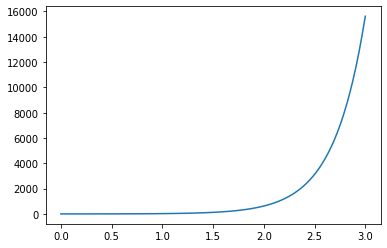

In [13]:
import numpy as np
x = np.linspace(0,3, 100)
y1, y2 = state_calculations(x, 2)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, y1)
# plt.yscale('log')
ax.ticklabel_format(style='plain')
plt.show()

del x, y1, y2

While the game is primarily played with two individuals, the 
game can be expanded to $n$ number of players. The task of 
permutating through the number of states amongst two players 
is relatively straightforward. As more players are added, 
approximation methods need to be utilized. As players are 
eliminated, the new state space can be mapped to a new game 
with $n-1$ players starting in a particular state. 
This project will examine the best policy for a game with 
3 players and create a framework for coming up with a 
efficient strategy for n players utilizing dynamic programming.
We will begin by trying to figure an efficient strategy for two
player and expand to $n+$ players. 

##### States and Rewards

In my initial tests, we can quickly see our ability to 
permute the state space is diminishing. Ferguson and 
Pumperla state, "If you could read out a hypothetical 
sequence all the way to the end of the game, you’d know 
who’d win; it’s easy to decide whether that’s a good 
sequence. But that’s not practical in any game more 
complex than tic-tac-toe: the number of possible 
variations is just too large" 
(Ferguson, Kevin; Pumperla, Max 2019). 

The game of Chopsticks has an interesting attribute. 
Upon a player being eliminated, a new game starts with 
$n-1$ players with a specific starting space. I'm hoping
that dynamic programming can take advantage of this;
however, I don't know how this will work yet. 

In [14]:
%%time
all_states = generate_states(2)
print(f"2 Players States: {len(all_states)}")

2 Players States: 625
CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 1.62 ms


In [15]:
%%time
print(f"3 Players States Generated: {len(generate_states(3))}")

3 Players States Generated: 15625
CPU times: user 18.2 ms, sys: 193 µs, total: 18.4 ms
Wall time: 18.6 ms


In [16]:
%%time
print(f" 4 Players States Generated: {len(generate_states(4))}")

 4 Players States Generated: 390625
CPU times: user 598 ms, sys: 21.7 ms, total: 620 ms
Wall time: 895 ms


In [17]:
r = [get_reward(state) for state in all_states]

## Chopsticks: 2 Players 

##### Transitions and Rewards

In order to use the MDPToolbox (*Chadès, Iadine, 
Guillaume Chapron, et al. 2014*), I need to have 
a square and stochastic transition matrix of shape 
(Actions, States, States). We already know that 
there are 625 different state combinations;
we easily calculate the 13 actions. We cannot simply 
multiple these to get the population of states because 
we are not interested in the next state but the next 
state for the player with the stochastic behavior of the
other player. In permutating these combinations, 
$5,078,125$ state-action pairs—a number of these combinations
are just to satisfy the MDPToolbox requirements.

In [18]:
# hand_pairs = []
# for i in range(0, 5):
#     for j in range(0, 5):
#         hand_pairs.append((j, i))

# all_states = []
# for i in range(len(hand_pairs)):
#     for j in range(len(hand_pairs)):
#         all_states.append([(hand_pairs[i][0], hand_pairs[i][1]),
#                      (hand_pairs[j][0], hand_pairs[j][1])])
        
# r = []
# for state in all_states:
#     r.append( -1 if state[0] == (0, 0) else (1 if state[1] == (0, 0) else 0))

In [19]:
def get_transition_matrix(all_states):
    index_map = {make_state_string(state): all_states.index(state) for state in all_states}

    actions = ['game_over']
    transitions = []

    for i in range(len(all_states)):
        j, o = all_states[i]
        for jj in range(0, len(j)):
            valid_send, _to = send_sticks(_from=j[jj], _to=o[0])
            action = ('send', jj, 0)
            if valid_send:
                if action not in actions:
                    actions.append(action)
                transitions.append({
                    'state': make_state_string(all_states[i]),
                    'next_state': make_state_string([(_to, o[1]), j]),
                    'action': actions.index(action),
                    'reward': r[index_map[make_state_string([(_to, o[1]), j])]]
                })
            else:
                if action not in actions:
                    actions.append(action)
                transitions.append({
                    'state': make_state_string(all_states[i]),
                    'next_state': make_state_string([(o[0], o[1]), (0,0)]),
                    'action': actions.index(action),
                    'reward': -1
                })

            valid_send, _to = send_sticks(_from=j[jj], _to=o[1])
            action = ('send', jj, 1)
            if valid_send:
                if action not in actions:
                    actions.append(action)
                transitions.append({
                    'state': make_state_string(all_states[i]),
                    'next_state': make_state_string([(o[0], _to), j]),
                    'action': actions.index(action),
                    'reward': r[index_map[make_state_string([(o[0], _to), j])]]
                })
            else:

                if action not in actions:
                    actions.append(action)
                transitions.append({
                    'state': make_state_string(all_states[i]),
                    'next_state': make_state_string([(o[0], o[1]), (0, 0)]),
                    'action': actions.index(action),
                    'reward': -1
                })

            for l in range(1, 5):
                #left to right
                if jj == 0:
                    f = 0
                    t = 1
                else:  # jj == 1:
                    f = 1
                    t = 0

                valid_split, _from, _to = split_2P(_from=j[f], _to=j[t], number_sent=l)
                action = ('split', f, t, l)
                if valid_split:
                    if action not in actions:
                        actions.append(action)
                    transitions.append({
                        'state': make_state_string(all_states[i]),
                        'next_state': make_state_string([o, (_from, _to)]),
                        'action': actions.index(action),
                        'reward': r[index_map[make_state_string([(_from, _to), o])]]
                    })
                else:
                    if action not in actions:
                        actions.append(action)
                    transitions.append({
                        'state': make_state_string(all_states[i]),
                        'next_state': make_state_string([o, (0, 0)]),
                        'action': actions.index(action),
                        'reward': -1
                    })

        action = ('game_over')
        if action not in actions:
            actions.append(action)
        
        if get_reward(all_states[i]) == 0:
            transitions.append({'state': make_state_string(all_states[i]),
                            'next_state': make_state_string([o, (0,0)]),
                            'action': actions.index(action),
                            'reward': -4
                            })
        else:
            transitions.append({'state': make_state_string(all_states[i]),
                            'next_state': make_state_string([o, j]),
                            'action': actions.index(action),
                            'reward': r[index_map[make_state_string([o, j])]]
                            })

    return transitions, actions 

In [20]:
def generate_transition_probabilities(transactions):
    action_states = pd.DataFrame([{"action": actions.index(action), 
                               "state": make_state_string(state),
                               "next_state": make_state_string(next_state)} for next_state in all_states for state in all_states for action in actions])

In [21]:
transitions, actions = get_transition_matrix(all_states)

In [22]:
action_states = pd.DataFrame([{"action": actions.index(action), 
                               "state": make_state_string(state),
                               "next_state": make_state_string(next_state)} for next_state in all_states for state in all_states for action in actions])

In [23]:
print(f"State Action Pairs: {action_states.shape[0]}")

State Action Pairs: 5078125


In [24]:
def generate_mdp_matrix(action_states, transitions):
    t = pd.DataFrame(transitions)
    t = t.merge(t[['state', 'next_state', 'reward']],
                how='inner',
                left_on='next_state',
                right_on='state')[['state_x', 'action', 'next_state_y', 'reward_y']]
    t.columns = ['state', 'action', 'next_state', 'reward']
    # p calculation
    p = (1 / (t[['state', 'action']].value_counts())).reset_index()
    t = action_states.merge(t.merge(p, left_on=['state', 'action'], right_on=['state', 'action']),
                            how='left',
                            left_on=['state', 'action', 'next_state'],
                            right_on=['state', 'action', 'next_state'])
    t.columns = ['action', 'state', 'next_state', 'reward', 'p']
    stocahstic_matrix_check = t.groupby(['state', 'action']).sum()[t.groupby(['state', 'action']).sum()['p'] == 0].reset_index()[['state', 'action', 'p']]
    stocahstic_matrix_check['p'] = np.ones(stocahstic_matrix_check.shape[0])

    #Finalize mdp matrix
    t=t.merge(stocahstic_matrix_check,
          how='left',
          left_on = ['action','state', 'next_state'],
          right_on=['action', 'state', 'state'])
    t['p_x'] = t['p_x'].fillna(t['p_y'])
    t['reward'] = t['reward'].fillna(0)
    t.drop('p_y', axis=1, inplace=True)
    t.columns = ['action','state','next_state','reward','p']
    return t

In [25]:
t = generate_mdp_matrix(action_states, transitions)

#### MDPToolbox Processing

After working through a lot of weird errors, I finally 
got MDPToolbox to finally accept my probability matrix. 
While I really want to formally compare the various 
outputs of MDPToolbox, I found that the policy
generated by many of the algorithms didn't seem correct.
I have spent a lot of hours playing with the rewards 
and discount to try to get something more reasonable. 

Using the Policy Iteration algorithm, it is evident that
the algorithm converges and in a reasonable time.

In [26]:
def execute_mdp(P, mdp_algorithm, all_states):
    P = P.groupby(['action','state','next_state']).agg({'reward': 'max', 'p': sum}).sort_values(['action','state']).reset_index()

    p_matrix = P.pivot(['action', 'state'], 'next_state', 'p').to_numpy().reshape(13, 625, 625)
    r_matrix = P.pivot(['action', 'state'], 'next_state', 'reward').to_numpy().reshape(13, 625, 625)

    mdp = mdp_algorithm(p_matrix,  r_matrix, .99)
    mdp.setSilent()
    mdp.run()
    state_action = []

    for i in range(len(all_states)):
        state_action.append({'policy_str': ','.join([str(j) for j in actions[mdp.policy[i]]]), 
                         'policy': mdp.policy[i],
                         'value': mdp.V[i],
                         'state': make_state_string(all_states[i])})
    
    policy = pd.DataFrame(state_action)
    return mdp, policy

In [27]:
mdp, policy = execute_mdp(t, ValueIteration, all_states)

I really began to notice my problem when I went through a game with two perfect players—as defined by the optimal policy. By 
reviewing a sample of policies, we can see the recommended policies appear—intuitively—correct. Yet, the policy—amongst all 
algorithms—wants to cheat with an invalid move when the current state almost surely is headed towards a loss. 

In [28]:
display(policy.sample(10, random_state=100)[['state', 'policy_str','value']])

,state,policy_str,value
462,"[(3,3),(2,2)]","send,0,0",98.040497
200,"[(1,3),(0,0)]","g,a,m,e,_,o,v,e,r",99.990058
397,"[(3,0),(4,2)]","send,0,1",97.607869
75,"[(0,3),(0,0)]","g,a,m,e,_,o,v,e,r",99.990058
259,"[(2,0),(1,4)]","send,0,1",97.776924
260,"[(2,0),(2,0)]","split,0,1,1",98.031200
513,"[(4,0),(2,3)]","send,0,1",97.596598
427,"[(3,2),(0,2)]","send,0,1",99.990058
376,"[(3,0),(0,1)]","split,0,1,1",97.839531
157,"[(1,1),(1,2)]","send,0,0",97.400688


In [29]:
policy[policy['state']=='[(1,1),(1,1)]']['policy_str'].iloc[0].split(",")

['send', '0', '0']

In [30]:
policy.to_json("2p.json")

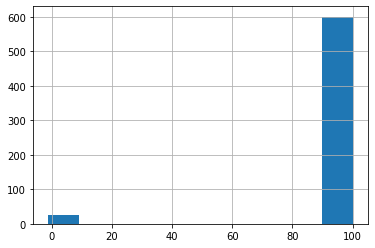

In [31]:
policy.value.hist()

### What Move Should I take?

The MDP policy really doesn't like defensive moves when playing with 2 players. When in doubt always attack your opponent.

In [32]:
policy.policy_str.value_counts()

## MDP Against Random CPU

When I used the policy against my random CPU, the MDP won $99%$ of the game regardless of which player took the first turn. When
the Policy plays against itself, a stale-mate occurs. This is where I would like to add adjust of the explore vs exploitation 
of my agent. It makes complete sense that the MDP would lose on occasion to a random player. However, I think this project could
be improved many ways including but not limited to: 1) adjusting the reward functions, 2) applying different algorithms, 3), allowing
the algorithm to choose moves probabilistically (ie doesn't always take the best move). The most astonishing thing was that the 
best policy from [Wikihow](https://www.wikihow.com/Always-Win-Chopsticks) article on _How to Always Win Chopsticks_ doesn't match the
policy generated by the MDP algorithm. I'll be looking into this and understand why. 

In this project, I originally set out to come up with a generic policy that could be used on $n$ players and $m$ hands. I wanted 
to learn more about the kd tree search algorithm that AlphaGo to help aid in large state spaces. Yet, I found myself really struggling
with wrangling the right transition matrix, the right state space, the sampling of the state space. In a lot of ways I feel like I totally bombed 
this project, yet, I feel like the struggle has allowed me to progress and puch through. That said, I feel like I failure in my initial 
goals and objects; however, I feel much more confident in implementing and utilizing the various MDP algorithms.

### 3 Players

I realize that I have to modify the function to get my transition matrix to get all the interactions between an $n$ number 
of states. This isn't an easy change and I'm running out time. I'm going to try to focus on evaluating this using my 
simulations; however, I don't feel that confident in my approach to getting all the states. My goal is to try to use something 
like the kd tree that AlphaGo uses. However, it is taking me a while to get through the book to try to build that out.

In [33]:
all_states = generate_states(3)
transitions, actions = get_transition_matrix(all_states)
action_states = pd.DataFrame([{"action": actions.index(action), 
                               "state": make_state_string(state),
                               "next_state": make_state_string(next_state)} for next_state in all_states for state in all_states for action in actions])
t = generate_mdp_matrix(action_states, transitions)
mdp, policy = execute_mdp(t, ValueIteration, all_states)

policy.value.hist()

ValueError: ValueError: too many values to unpack (expected 2)

### Random Simulation

After building the game, a series of random simulations were used to test the code. Instead of throwing these simulated games 
away, I am going to try to use them to establish baseline probabilities to try to jump start the reinforcement algorithm. 

#### Initial Observation given Random Simulations

Given the fairly large sample of random states from testing, we can clearly see that the majority of the states have negative 
values. Initial observations yield that all states possess a negative value. This makes sense given two reasons: 1) each player 
has a 2/3 chance of losing and 2) there are significantly more losing states than winning states. 

### 3 Players 

This was my first attempt at this whole project; however, I couldn't quite get the data and the algorithm appropriate 
wrangled together. From my brief-potentially wrong- analysis. The game changes from 2 to 3 player from an offensive 
game to a more defensive. With 3 players, it appears that the goal is to survive and the likelihood of losing is 
$\frac{2}{3}$ at base. That said, my initial thought was to switch to a 2 player game when a player was eliminated. 
But I think that I am going to have settle for comparing some of the values of states for two people.

##### Manual Bellman Equation Implementation

In [2]:
state = pd.read_json("state_change_matrix.json")

In [3]:
state_value = state[['s','s_prime','p','reward_prime']].drop_duplicates()
all_states = pd.DataFrame(pd.concat([state['s'], state['s_prime']]).drop_duplicates(), columns=['s'])

state_value = all_states.merge(state_value, how='left',left_on='s', right_on='s').set_index('s').sort_index()
rewards = pd.merge(left=all_states, right=state_value[['s_prime','reward_prime']].drop_duplicates(), left_on='s',right_on='s_prime', how='left', suffixes=('','_value'))[['s','reward_prime']].set_index('s').sort_index()
rewards = rewards.dropna()

state_value = state_value.merge(rewards, right_index=True, left_index=True)
state_value['s_prime'] = state_value.apply(lambda row: row.name if (row['reward_prime_y'] != 0 or row['reward_prime_y'] is np.nan)  else row['s_prime'] , axis = 1)
state_value = state_value.drop(['reward_prime_x', 'reward_prime_y'], axis=1)
state_value_1 = state_value[~state_value['s_prime'].isna()].reset_index()
P = state_value_1.pivot('s','s_prime','p').fillna(0).sort_index()
v = rewards.to_numpy()
for i in range(0, 1000):
    v = rewards.to_numpy() + .99 * np.dot(P.to_numpy(), v)

# References

Chadès, Iadine, Guillaume Chapron, Marie‐Josée Cros, Frédérick Garcia, and Régis Sabbadin.
"MDPtoolbox: a multi‐platform toolbox to solve stochastic dynamic programming problems." Ecography
37, no. 9 (2014): 916-920.

Pumperla, M., & Ferguson, K. (2019). Deep learning and the game of go. Manning Publications.

Richard S. Sutton and Andrew G. Barto. 2018. Reinforcement Learning: An Introduction. A Bradford Book, Cambridge, MA, USA.

RL Course by David Silver - Lecture 2: Markov Decision Process https://www.youtube.com/watch?v=lfHX2hHRMVQ&list=PLqYmG7hTraZBiG_XpjnPrSNw-1XQaM_gB&index=3

Silver, D., Huang, A., Maddison, C. et al. Mastering the game of Go with deep neural networks and tree search. Nature 529, 484–489 (2016). https://doi.org/10.1038/nature16961

### Baby's Schedule

My wife and I typically have kept vigilant records of the first couple of months of life for both our children. We have 
found that this helps with their overall health and wellness by establishing good, consistent routines; as well as our own 
mental health. We can quickly diagnose problems or reasons for them being upset with relative ease through expectation regarding 
the inter-arrival time of naps, food, and bowel movements and the renewals of the daily epochs. I am also expecting to see different behavior from us being
having no experience as a parent vs having the experience of already having a child.  

As is customary, I fully expect the inter-arrival times of activities to follow an exponential distribution and 
the number of naps in a given day to mirror to be a Poisson process. 


In [220]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [221]:
pyro.enable_validation(True)
pyro.set_rng_seed(1250)

In [257]:
schedule = pd.read_csv("baby_data.csv").iloc[:,1:]
schedule.Time = pd.to_datetime(schedule.Time)

schedule['next_activity_time'] = schedule.groupby('Baby').shift(-1)['Time']
schedule['next_activity'] = schedule.groupby('Baby').shift(-1)['activity']
schedule['diff'] = (schedule['next_activity_time'] - schedule.Time).dt.components['hours']
schedule["Duration(minutes)"] = pd.to_timedelta(schedule["Duration(minutes)"].fillna(1), 'minute')
schedule = schedule.reset_index()

## Long Term Probabilities

I remember telling one of the first babysitters, " If Addie Mae gets upset you have a 1/3 chance that she needs sleep, food 
or a diaper change." While this statement is true about the reason for the problem-especially for an infant, the probabilities
might not neccessarily be truly a third.

After looking at the long-run probabilities, I can quickly give a babysitter the order in which I would try to calm our upset 
child. These results have flabbergasted my wife and I, we would have never expected that my second child would have a higher 
probability of being in a state of nursing. My wife makes several comments about how it seems like she was always feeding our 
first because of the uncertainty that is partnered with being a first time parent. After some careful consideration, I think it 
would be wise to condition the probability on the child's age. Since my youngest hasn't hit the same stages where she is eating 3 or 4
distinct meals, I think it would be more insightful to see this conditioned on the age of the child.

#### Transition Probability Matrix

In [258]:
activity_matrix = schedule.groupby(['Baby', 'activity','next_activity']).agg({'Time': 'count'}).reset_index().pivot(['Baby','activity'], 'next_activity','Time')

states = activity_matrix.columns

activity_matrix = activity_matrix.div(activity_matrix.sum(axis=1), axis=0).fillna(0)

activity_matrix

next_activity 
 diaper 
 nursing 
 sleep 
 
 
 Baby 
 activity 
 
 
 
 
 
 
 
 1 
 diaper 
 0.143791 
 0.856209 
 0.000000 
 
 
 nursing 
 0.079684 
 0.181265 
 0.739051 
 
 
 sleep 
 0.000000 
 0.695702 
 0.304298 
 
 
 2 
 diaper 
 0.111111 
 0.648148 
 0.240741 
 
 
 nursing 
 0.026391 
 0.226047 
 0.747562 
 
 
 sleep 
 0.001235 
 0.810994 
 0.187770

#### Long Term Probabilities

In [259]:

am = activity_matrix.to_numpy().reshape(2,3,3)

p_state_t = []
for i in range(len(am)):
    p_state_t.append([])
    a = np.zeros(3)
    a.put(2, 1)
    for j in range(10**4):
        a = a @ am[i] 
        p_state_t[i].append(a)

pd.concat([pd.DataFrame(p_state_t[0][-1], index=states.rename("Activity"), columns=["Child 1"]),
           pd.DataFrame(p_state_t[1][-1], index=states, columns=["Child 2"])], axis=1)

,Child 1,Child 2
diaper,0.043178,0.015803
nursing,0.463956,0.510062
sleep,0.492865,0.474136


## Renewal Theory

We have established that the inter-arrival times in a state is exponential; however, I feel that there is more that I can 
do with this data particularly using renewal theory and Semi-Markov processes. I would really like to try to identify changes 
in sleep patterns as both my children age out of the infant and toddler phases. 

### Inter-arrival Times

Using the eyeball test, the inter-arrival times betweena activities appears to match to a geometric distribution. 
However, we can also tell that there is some divergence from the distribution. My intial guess is that this occurs over-night; 
once the child begins sleeping through the night. I wonder what would happen if I fully made this a renewal process with something
like an end of day state. 

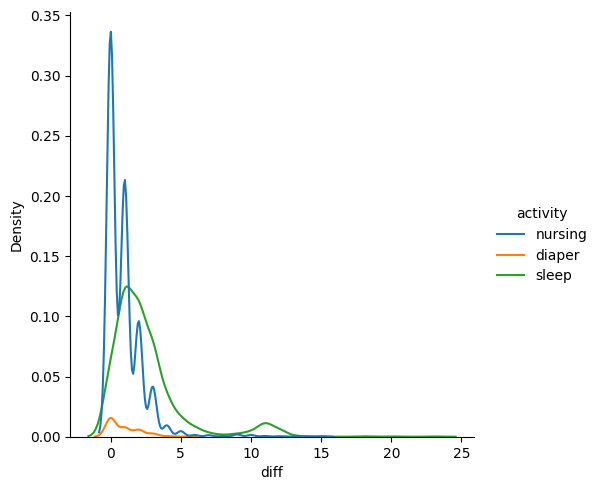

In [260]:
sns.displot(x=schedule['diff'], hue=schedule['activity'], kind="kde")

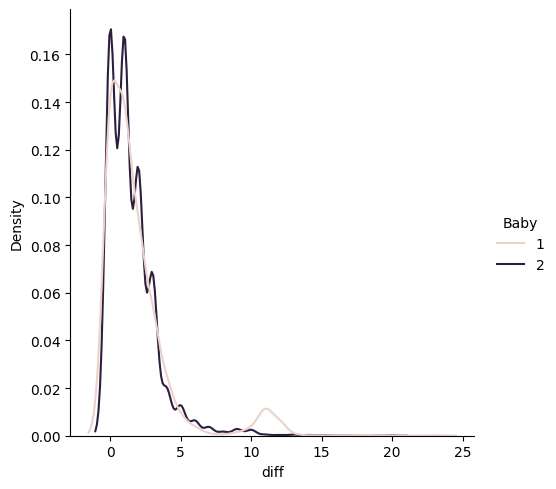

In [261]:
sns.displot(x=schedule['diff'], hue=schedule['Baby'], kind='kde')

In [262]:
awake_time = pd.DataFrame(schedule['Time'] + schedule["Duration(minutes)"], columns=['Time'])
awake_time['activity'] = 'wake'
awake_time['Baby'] = schedule['Baby']

In [265]:
schedule = pd.concat([schedule, awake_time]).sort_values('Time')
schedule['next_activity_time'] = schedule.groupby('Baby').shift(-1)['Time']
schedule['next_activity'] = schedule.groupby('Baby').shift(-1)['activity']
schedule['prior_activity'] = schedule.groupby('Baby').shift(1)['activity']
schedule['diff'] = (schedule['next_activity_time'] - schedule.Time).dt.components['hours']

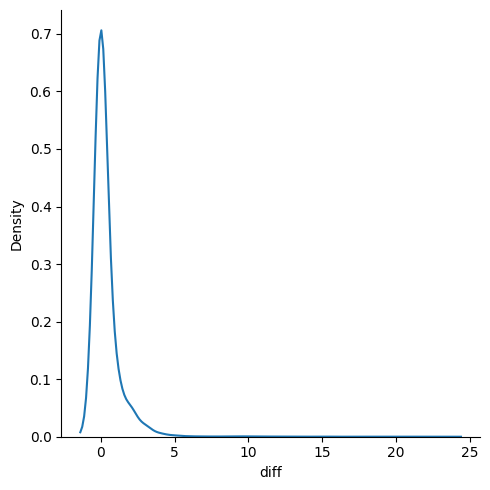

In [277]:
from scipy.stats import expon
sns.displot(schedule[schedule['activity']=='wake']['diff'], kind='kde', bw_adjust=3)

# Markov Reward Process

In [64]:

# state_value = state[['s','s_prime','p','reward_prime']].drop_duplicates()
# all_states = pd.DataFrame(pd.concat([state['s'], state['s_prime']]).drop_duplicates(), columns=['s'])

# state_value = all_states.merge(state_value, how='left',left_on='s', right_on='s').set_index('s').sort_index()
# rewards = pd.merge(left=all_states, right=state_value[['s_prime','reward_prime']].drop_duplicates(), left_on='s',right_on='s_prime', how='left', suffixes=('','_value'))[['s','reward_prime']].set_index('s').sort_index()
# rewards = rewards.dropna()

# state_value = state_value.merge(rewards, right_index=True, left_index=True)
# state_value['s_prime'] = state_value.apply(lambda row: row.name if (row['reward_prime_y'] != 0 or row['reward_prime_y'] is np.nan)  else row['s_prime'] , axis = 1)
# state_value = state_value.drop(['reward_prime_x', 'reward_prime_y'], axis=1)
# state_value_1 = state_value[~state_value['s_prime'].isna()].reset_index()
# P = state_value_1.pivot('s','s_prime','p').fillna(0).sort_index()
# v = rewards.to_numpy()
# for i in range(0, 1000):
#     v = rewards.to_numpy() + np.dot(P.to_numpy(), v)